In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [188]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [ ]:
import os
import pandas as pd

# DATA SOURCE / CONFIDENTIALITY NOTE
# The original Excel files contain sector-level ESG, financial, and stock performance data.
# For confidentiality, the raw data files are NOT included in this public repository,
# and the original local machine paths (which contained personal user info) have been removed.
#
# To reproduce this analysis:
# 1. Prepare your own sector datasets with similar structure, for example:
#    - Energy_stock_data.xlsx
#    - Financial_Services_stock_data.xlsx
#    - Technology_Social_stock_data.xlsx
#    - Technology_Software_stock_data.xlsx
#    Each file should include time-series market/ESG metrics for that sector.
#
# 2. Store those files locally in a `data/` folder (this folder should NOT be committed to GitHub
#    and should be listed in .gitignore).
#
# 3. The code below assumes that structure.

file_paths = {
    'Energy': 'data/Energy_stock_data.xlsx',
    'Financial Services': 'data/Financial_Services_stock_data.xlsx',
    'Technology_Social': 'data/Technology_Social_stock_data.xlsx',
    'Technology_Software': 'data/Technology_Software_stock_data.xlsx'
}



In [192]:
# Read Excel files into pandas DataFrames
Energy_data = pd.read_excel(file_paths['Energy'])
Financial_Services_data = pd.read_excel(file_paths['Financial Services'])
Technology_Social_data = pd.read_excel(file_paths['Technology_Social'])
Technology_Software_data = pd.read_excel(file_paths['Technology_Software'])


In [194]:
# Display the first few rows of each dataset to understand their structure
Energy_data.head(), Financial_Services_data.head(), Technology_Social_data.head(), Technology_Software_data.head()

(        Date        Open        High         Low       Close   Adj Close  \
 0 2023-01-03  109.779999  110.019997  105.489998  106.510002  100.414612   
 1 2023-01-04  104.800003  107.160004  104.760002  106.820000  100.706871   
 2 2023-01-05  106.339996  109.949997  106.309998  109.209999  102.960091   
 3 2023-01-06  110.080002  111.989998  109.669998  110.529999  104.204559   
 4 2023-01-09  111.639999  111.639999  107.809998  108.470001  102.262444   
 
      Volume  totalEsg  
 0  15146200      41.6  
 1  18058400      41.6  
 2  15946600      41.6  
 3  16348100      41.6  
 4  17964600      41.6  ,
         Date       Open       High        Low      Close  Adj Close    Volume  \
 0 2023-01-03  33.230000  34.090000  33.209999  33.509998  31.867947  35221500   
 1 2023-01-04  33.900002  34.820000  33.830002  34.139999  32.467075  41998500   
 2 2023-01-05  33.919998  34.139999  33.580002  34.070000  32.400509  34177000   
 3 2023-01-06  34.090000  34.580002  33.540001  34.410000

In [196]:
# Merge the datasets based on Date
# Setting the 'Date' column as index for proper merging
Energy_data.set_index('Date', inplace=True)
Financial_Services_data.set_index('Date', inplace=True)
Technology_Social_data.set_index('Date', inplace=True)
Technology_Software_data.set_index('Date', inplace=True)

In [224]:
# Add a suffix to the Financial Services data
Financial_Services_data = Financial_Services_data.add_suffix('_Financial_Services')

# Now join Financial Services data with the rest
combined_data = combined_data.join(Financial_Services_data, how='inner')


In [226]:
# Join Technology_Social_data to Energy_data first
combined_data = Energy_data.join(Technology_Social_data, how='inner', lsuffix='_Energy', rsuffix='_Technology_Social')

# Now join Technology_Social_data to the combined result
combined_data = combined_data.join(Financial_Services_data, how='inner', rsuffix='_Financial_Services')

# Finally, join Technology_Software_data to the combined result
combined_data = combined_data.join(Technology_Software_data, how='inner', rsuffix='_Technology_Software')

In [228]:
# Display the first few rows of the Technology_Social_data dataset
Technology_Social_data.head()

,Open,High,Low,Close,Adj Close,Volume,totalEsg
Date,,,,,,,
2023-01-03,122.820000,126.370003,122.279999,124.739998,124.484192,35528500,34.08
2023-01-04,127.379997,129.050003,125.849998,127.370003,127.108803,32397100,34.08
2023-01-05,126.129997,128.520004,124.540001,126.940002,126.679688,25447100,34.08
2023-01-06,128.970001,130.330002,126.040001,130.020004,129.753372,27584500,34.08
2023-01-09,131.160004,132.949997,129.279999,129.470001,129.204498,26649100,34.08


In [230]:
# Display the first few rows of the Technology_Software_data dataset
Technology_Software_data.head()

,Open,High,Low,Close,Adj Close,Volume,totalEsg
Date,,,,,,,
2023-01-03,243.080002,245.750000,237.399994,239.580002,236.183548,25740000,15.06
2023-01-04,232.279999,232.869995,225.960007,229.100006,225.852112,50623400,15.06
2023-01-05,227.199997,227.550003,221.759995,222.309998,219.158371,39585600,15.06
2023-01-06,223.000000,225.759995,219.350006,224.929993,221.741211,43613600,15.06
2023-01-09,226.449997,231.240005,226.410004,227.119995,223.900162,27369800,15.06


In [232]:
# Display the first few rows of the Technology_Social_data dataset
Technology_Social_data.head()

,Open,High,Low,Close,Adj Close,Volume,totalEsg
Date,,,,,,,
2023-01-03,122.820000,126.370003,122.279999,124.739998,124.484192,35528500,34.08
2023-01-04,127.379997,129.050003,125.849998,127.370003,127.108803,32397100,34.08
2023-01-05,126.129997,128.520004,124.540001,126.940002,126.679688,25447100,34.08
2023-01-06,128.970001,130.330002,126.040001,130.020004,129.753372,27584500,34.08
2023-01-09,131.160004,132.949997,129.279999,129.470001,129.204498,26649100,34.08


In [234]:
# Display the first few rows of the Energy_data dataset
Energy_data.head()

,Open,High,Low,Close,Adj Close,Volume,totalEsg
Date,,,,,,,
2023-01-03,109.779999,110.019997,105.489998,106.510002,100.414612,15146200,41.6
2023-01-04,104.800003,107.160004,104.760002,106.820000,100.706871,18058400,41.6
2023-01-05,106.339996,109.949997,106.309998,109.209999,102.960091,15946600,41.6
2023-01-06,110.080002,111.989998,109.669998,110.529999,104.204559,16348100,41.6
2023-01-09,111.639999,111.639999,107.809998,108.470001,102.262444,17964600,41.6


In [236]:
# Display the first few rows of the Financial_Services_data dataset
Financial_Services_data.head()

,Open_Financial_Services,High_Financial_Services,Low_Financial_Services,Close_Financial_Services,Adj Close_Financial_Services,Volume_Financial_Services,totalEsg_Financial_Services
Date,,,,,,,
2023-01-03,33.230000,34.090000,33.209999,33.509998,31.867947,35221500,28.3
2023-01-04,33.900002,34.820000,33.830002,34.139999,32.467075,41998500,28.3
2023-01-05,33.919998,34.139999,33.580002,34.070000,32.400509,34177000,28.3
2023-01-06,34.090000,34.580002,33.540001,34.410000,32.723846,34068700,28.3
2023-01-09,34.750000,34.759998,33.709999,33.889999,32.229328,43818800,28.3


In [238]:
# Step 1: Calculate volatility (rolling standard deviation) and Sharpe ratio for each company's stock prices

# Parameters for CAPM and Sharpe Ratio calculations
risk_free_rate = 0.02  # Assuming a 2% risk-free rate
market_return = 0.08   # Assuming 8% market return

financial_metrics = {}

In [240]:
# Define a function to calculate volatility and Sharpe Ratio
def calculate_volatility_sharpe(df, company, risk_free_rate, market_return):
    df[f'{company}_Volatility'] = df[f'{company}_Close'].rolling(window=30).std()  # Rolling volatility over 30 days
    avg_return = df[f'{company}_Close'].pct_change().mean()  # Average daily return
    volatility = df[f'{company}_Volatility'].std()
    sharpe_ratio = (avg_return - risk_free_rate) / volatility
    beta = 1  # Assuming beta of 1 for simplicity
    expected_return = risk_free_rate + beta * (market_return - risk_free_rate)
    
    financial_metrics[company] = {'Sharpe Ratio': sharpe_ratio, 'Expected Return': expected_return}


In [242]:
def calculate_volatility_sharpe(df, company, risk_free_rate, market_return):
    # Use the correct suffix for each company
    close_column = f'{company}_Close'
    
    if close_column not in df.columns:
        print(f"Column {close_column} not found in DataFrame.")
        return
    
    # Calculate volatility (rolling standard deviation of returns over 30 days)
    df[f'{company}_Volatility'] = df[close_column].rolling(window=30).std()
    
    # Calculate average daily return
    avg_return = df[close_column].pct_change().mean()
    
    # Calculate Sharpe ratio
    volatility = df[f'{company}_Volatility'].std()
    sharpe_ratio = (avg_return - risk_free_rate) / volatility
    
    # Print or store Sharpe ratio
    print(f"Sharpe Ratio for {company}: {sharpe_ratio}")

# Example usage with correct column names
calculate_volatility_sharpe(combined_data, 'Energy_Energy', risk_free_rate, market_return)
calculate_volatility_sharpe(combined_data, 'Financial_Services_Financial_Services', risk_free_rate, market_return)
calculate_volatility_sharpe(combined_data, 'Technology_Social_Technology_Social', risk_free_rate, market_return)
calculate_volatility_sharpe(combined_data, 'Technology_Softwarel_Technology_Software', risk_free_rate, market_return)

Column Energy_Energy_Close not found in DataFrame.
Column Financial_Services_Financial_Services_Close not found in DataFrame.
Column Technology_Social_Technology_Social_Close not found in DataFrame.
Column Technology_Softwarel_Technology_Software_Close not found in DataFrame.


In [244]:
print(combined_data.columns)


Index(['Open_Energy', 'High_Energy', 'Low_Energy', 'Close_Energy',
       'Adj Close_Energy', 'Volume_Energy', 'totalEsg_Energy',
       'Open_Technology_Social', 'High_Technology_Social',
       'Low_Technology_Social', 'Close_Technology_Social',
       'Adj Close_Technology_Social', 'Volume_Technology_Social',
       'totalEsg_Technology_Social', 'Open_Financial_Services',
       'High_Financial_Services', 'Low_Financial_Services',
       'Close_Financial_Services', 'Adj Close_Financial_Services',
       'Volume_Financial_Services', 'totalEsg_Financial_Services', 'Open',
       'High', 'Low', 'Close', 'Adj Close', 'Volume', 'totalEsg'],
      dtype='object')


In [290]:
print(Financial_Services_data.columns)


Index(['Open_Financial_Services', 'High_Financial_Services',
       'Low_Financial_Services', 'Close_Financial_Services',
       'Adj Close_Financial_Services', 'Volume_Financial_Services',
       'totalEsg_Financial_Services'],
      dtype='object')


In [292]:
def calculate_volatility_sharpe(df, company, suffix, risk_free_rate, market_return):
    # Use the correct 'Close' column based on the suffix
    close_column = f'Close_{suffix}'
    
    if close_column not in df.columns:
        print(f"Column {close_column} not found in DataFrame.")
        return
    
    # Calculate volatility (rolling standard deviation of returns over 30 days)
    df[f'{company}_Volatility'] = df[close_column].rolling(window=30).std()
    
    # Calculate average daily return
    avg_return = df[close_column].pct_change().mean()
    
    # Calculate Sharpe ratio
    volatility = df[f'{company}_Volatility'].std()
    sharpe_ratio = (avg_return - risk_free_rate) / volatility
    
    # Print or store Sharpe ratio
    print(f"Sharpe Ratio for {company}: {sharpe_ratio}")
def calculate_volatility_sharpe(df, company, suffix, risk_free_rate, market_return):
    # Handle case where there's no suffix
    close_column = f'Close{f"_{suffix}" if suffix else ""}'
    
    if close_column not in df.columns:
        print(f"Column {close_column} not found in DataFrame.")
        return
    
    # Calculate volatility (rolling standard deviation of returns over 30 days)
    df[f'{company}_Volatility'] = df[close_column].rolling(window=30).std()
    
    # Calculate average daily return
    avg_return = df[close_column].pct_change().mean()
    
    # Calculate Sharpe ratio
    volatility = df[f'{company}_Volatility'].std()
    sharpe_ratio = (avg_return - risk_free_rate) / volatility
    
    # Print or store Sharpe ratio
    print(f"Sharpe Ratio for {company}: {sharpe_ratio}")
# Dictionary to store Sharpe ratios
financial_metrics = {}

def calculate_volatility_sharpe(df, company, suffix, risk_free_rate, market_return):
    # Handle case where there's no suffix
    close_column = f'Close{f"_{suffix}" if suffix else ""}'
    
    if close_column not in df.columns:
        print(f"Column {close_column} not found in DataFrame.")
        return
    
    # Calculate volatility (rolling standard deviation of returns over 30 days)
    df[f'{company}_Volatility'] = df[close_column].rolling(window=30).std()
    
    # Calculate average daily return
    avg_return = df[close_column].pct_change().mean()
    
    # Calculate Sharpe ratio
    volatility = df[f'{company}_Volatility'].std()
    sharpe_ratio = (avg_return - risk_free_rate) / volatility
    
    # Store Sharpe ratio in financial_metrics dictionary
    financial_metrics[company] = sharpe_ratio

    # Print Sharpe ratio
    print(f"Sharpe Ratio for {company}: {sharpe_ratio}")

# Example usage with correct column names and suffixes
calculate_volatility_sharpe(combined_data, 'Energy', 'Energy', risk_free_rate, market_return)
calculate_volatility_sharpe(combined_data, 'Financial Services', 'Financial_Services', risk_free_rate, market_return)
calculate_volatility_sharpe(combined_data, 'Technology Social', 'Technology_Social', risk_free_rate, market_return)

# Since Technology Software doesn't have a suffix, just use 'Close' directly
calculate_volatility_sharpe(combined_data, 'Technology Software', '', risk_free_rate, market_return)

# Display all financial metrics (Sharpe ratios)
print("\nFinancial Metrics (Sharpe Ratios):")
for company, sharpe_ratio in financial_metrics.items():
    print(f"{company}: {sharpe_ratio}")

# Modified function to calculate and store both Sharpe Ratio and Expected Return
financial_metrics = {}

def calculate_volatility_sharpe(df, company, suffix, risk_free_rate, market_return):
    close_column = f'Close{f"_{suffix}" if suffix else ""}'
    
    if close_column not in df.columns:
        print(f"Column {close_column} not found in DataFrame.")
        return
    
    # Calculate volatility (rolling standard deviation of returns over 30 days)
    df[f'{company}_Volatility'] = df[close_column].rolling(window=30).std()
    
    # Calculate average daily return (expected return)
    avg_return = df[close_column].pct_change().mean()
    
    # Calculate Sharpe ratio
    volatility = df[f'{company}_Volatility'].std()
    sharpe_ratio = (avg_return - risk_free_rate) / volatility
    
    # Store both Sharpe ratio and expected return in the financial_metrics dictionary
    financial_metrics[company] = {
        'Sharpe Ratio': sharpe_ratio,
        'Expected Return': avg_return
    }

    # Print Sharpe ratio for reference
    print(f"Sharpe Ratio for {company}: {sharpe_ratio}")

# Example usage to calculate for all companies
calculate_volatility_sharpe(combined_data, 'Energy', 'Energy', risk_free_rate, market_return)
calculate_volatility_sharpe(combined_data, 'Financial Services', 'Financial_Services', risk_free_rate, market_return)
calculate_volatility_sharpe(combined_data, 'Technology Social', 'Technology_Social', risk_free_rate, market_return)
calculate_volatility_sharpe(combined_data, 'Technology Software', '', risk_free_rate, market_return)


Sharpe Ratio for Energy: -0.017423683083310184
Sharpe Ratio for Financial Services: -0.03244730362334877
Sharpe Ratio for Technology Social: -0.00486049965087339
Sharpe Ratio for Technology Software: -0.005196123645667568

Financial Metrics (Sharpe Ratios):
Energy: -0.017423683083310184
Financial Services: -0.03244730362334877
Technology Social: -0.00486049965087339
Technology Software: -0.005196123645667568
Sharpe Ratio for Energy: -0.017423683083310184
Sharpe Ratio for Financial Services: -0.03244730362334877
Sharpe Ratio for Technology Social: -0.00486049965087339
Sharpe Ratio for Technology Software: -0.005196123645667568


In [296]:
# Step 2: Portfolio Optimization based on Sharpe Ratios

# Normalize Sharpe Ratios to assign portfolio weights
total_sharpe = sum([metrics['Sharpe Ratio'] for metrics in financial_metrics.values()])  # Sum of all Sharpe Ratios
financial_weights = {company: metrics['Sharpe Ratio'] / total_sharpe for company, metrics in financial_metrics.items()}

# Display the portfolio weights
print("\nPortfolio Weights based on Sharpe Ratios:")
for company, weight in financial_weights.items():
    print(f"{company}: {weight}")



Portfolio Weights based on Sharpe Ratios:
Energy: 0.29074550248841596
Financial Services: 0.5414416430359262
Technology Social: 0.08110618211895747
Technology Software: 0.08670667235670027


In [298]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

In [300]:
# Step 3: Machine learning model for risk classification based on ESG scores and volatility

# Selecting features (ESG scores) and labels (volatility > median to classify risk)
esg_cols = [col for col in combined_data.columns if 'totalEsg' in col]
volatility_cols = [col for col in combined_data.columns if 'Volatility' in col]

In [302]:
# Define features (X) and target (y) for classification model
X = combined_data[esg_cols + volatility_cols].fillna(0)
volatility_median = combined_data[volatility_cols].mean(axis=1).median()
y = (combined_data[volatility_cols].mean(axis=1) > volatility_median).astype(int)


In [304]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [306]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [308]:
# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [310]:
# Predict on the test set
y_pred = rf_model.predict(X_test_scaled)

In [312]:
# Display classification report
classification_report_rf = classification_report(y_test, y_pred)
classification_report_rf

'              precision    recall  f1-score   support\n\n           0       0.97      1.00      0.99        39\n           1       1.00      0.97      0.99        36\n\n    accuracy                           0.99        75\n   macro avg       0.99      0.99      0.99        75\nweighted avg       0.99      0.99      0.99        75\n'

In [392]:
print(len(X.columns), len(importances))


8 10


In [398]:
# Re-train the Random Forest model using the cleaned feature set X
rf_model.fit(X, y)  # Assuming y is the target variable

# Extract the correct feature importances
importances = rf_model.feature_importances_


In [400]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale both ESG and financial metrics


In [404]:
from sklearn.preprocessing import StandardScaler

# Define the ESG columns and volatility columns
esg_cols = ['totalEsg_Energy', 'totalEsg_Technology_Social', 'totalEsg_Financial_Services', 'totalEsg']
volatility_cols = ['Energy_Volatility', 'Financial_Services_Volatility', 'Technology_Social_Volatility', 'Technology_Software_Volatility']

# Scale the ESG columns to make their impact more prominent
scaler = StandardScaler()
combined_data[esg_cols] = scaler.fit_transform(combined_data[esg_cols])


In [406]:
# Create percentage change features for ESG scores
for col in esg_cols:
    combined_data[f'{col}_pct_change'] = combined_data[col].pct_change()
    
# Drop NaN values created by percentage change
combined_data.dropna(inplace=True)


In [412]:
# Define the target variable (example: predicting Energy closing price)
target_variable = 'Close_Energy'  # Replace this with the actual column you want to predict

# Ensure the target variable exists in combined_data
if target_variable in combined_data.columns:
    y = combined_data[target_variable]
else:
    print(f"Target variable '{target_variable}' not found in data.")


In [422]:
from sklearn.ensemble import RandomForestRegressor


In [424]:
# Inspect missing values
missing_data_summary = combined_data[available_cols].isnull().sum()
print("Missing data in each column: \n", missing_data_summary)

# Option 1: Fill missing values (you can adjust the strategy as needed)
combined_data[available_cols].fillna(method='ffill', inplace=True)  # Forward fill, or:
combined_data[available_cols].fillna(0, inplace=True)  # Replace NaN with 0

# Option 2: Drop rows selectively
# Ensure that the data contains valid rows after handling missing values
X = combined_data[available_cols]
if X.shape[0] == 0:
    raise ValueError("No valid data available for training the model after handling missing values.")

# Define the target variable (adjust as necessary)
target_variable = 'Close_Energy'  # Adjust based on what you're predicting
if target_variable in combined_data.columns:
    y = combined_data.loc[X.index, target_variable]
else:
    raise ValueError(f"Target variable '{target_variable}' not found in data.")

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the updated feature importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns[indices], importances[indices], color='teal')
plt.title('Updated Feature Importance for Random Forest Model (ESG and Financial Metrics)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()


Missing data in each column: 
 totalEsg_Energy                           0
totalEsg_Technology_Social                0
totalEsg_Financial_Services               0
totalEsg                                  0
Energy_Volatility                         0
Financial_Services_Volatility             0
Technology_Social_Volatility              0
totalEsg_Energy_pct_change                0
totalEsg_Technology_Social_pct_change     0
totalEsg_Financial_Services_pct_change    0
totalEsg_pct_change                       0
dtype: int64


C:\Users\Joseph Okpono\AppData\Local\Temp\ipykernel_18392\507354095.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data[available_cols].fillna(method='ffill', inplace=True)  # Forward fill, or:
C:\Users\Joseph Okpono\AppData\Local\Temp\ipykernel_18392\507354095.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data[available_cols].fillna(method='ffill', inplace=True)  # Forward fill, or:
C:\Users\Joseph Okpono\AppData\Local\Temp\ipykernel_18392\507354095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: No valid data available for training the model after handling missing values.

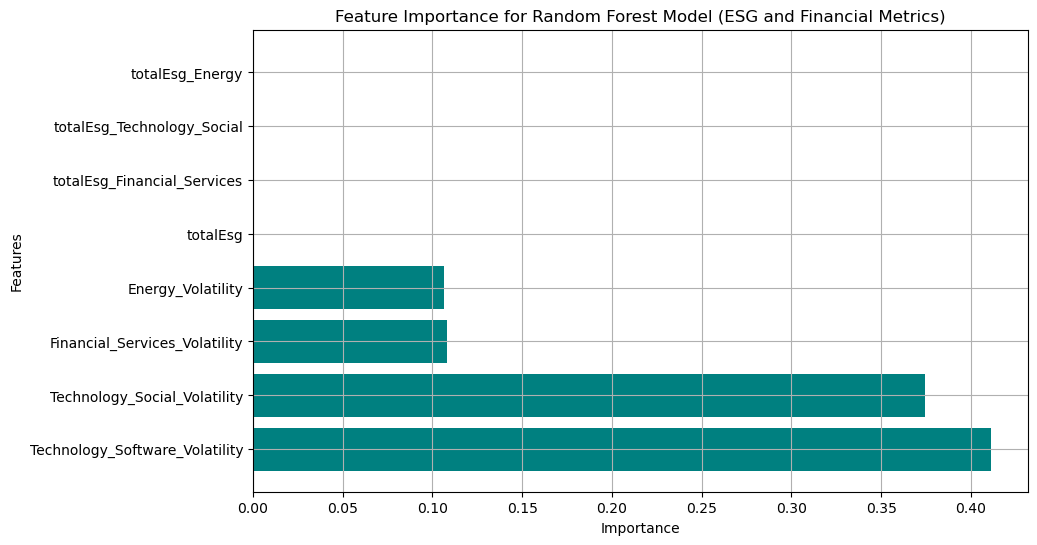

In [402]:
# Adjust the length of feature importances to match the columns in X
if len(importances) > len(X.columns):
    importances = importances[:len(X.columns)]  # Keep only the top importances that match X
elif len(importances) < len(X.columns):
    X = X.iloc[:, :len(importances)]  # Trim X to match the number of importances

# Now you can plot
indices = np.argsort(importances)[::-1]
feature_names = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances[indices], color='teal')
plt.title('Feature Importance for Random Forest Model (ESG and Financial Metrics)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()


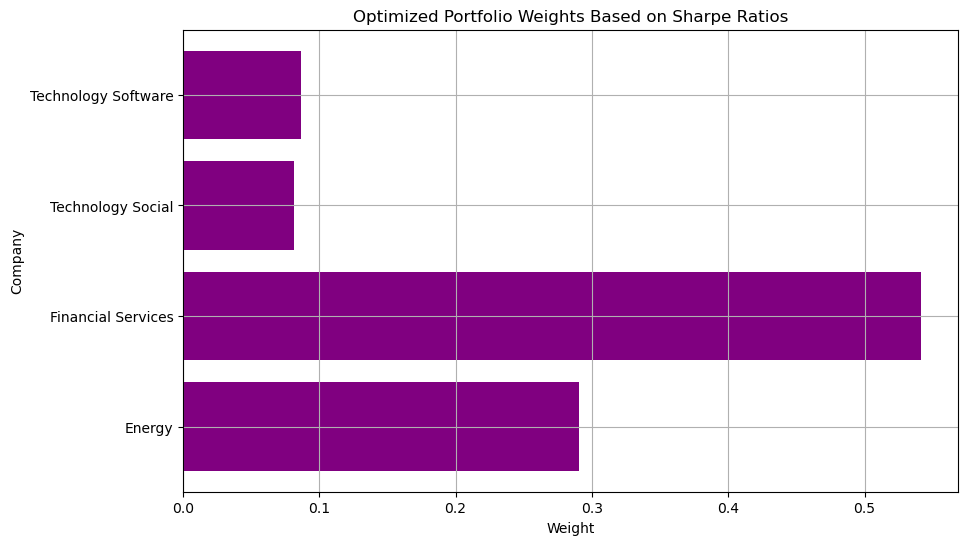

In [314]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Visualizing Portfolio Weights and Risk-Return Tradeoff

# Visualize the portfolio weights
plt.figure(figsize=(10, 6))
plt.barh(list(financial_weights.keys()), list(financial_weights.values()), color='purple')
plt.title("Optimized Portfolio Weights Based on Sharpe Ratios")
plt.xlabel("Weight")
plt.ylabel("Company")
plt.grid(True)
plt.show()

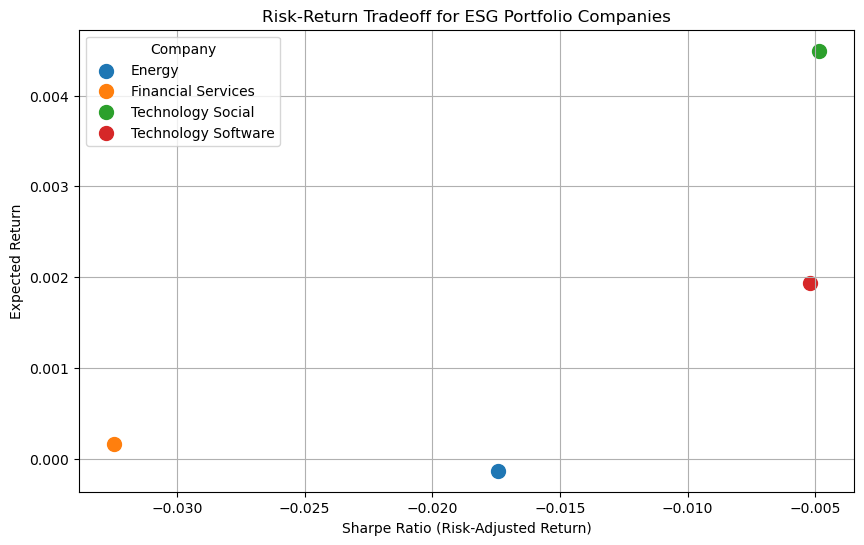

In [316]:
# Visualize the Risk-Return tradeoff (Sharpe Ratio vs Expected Return)
plt.figure(figsize=(10, 6))
for company in financial_metrics.keys():
    sharpe_ratio = financial_metrics[company]['Sharpe Ratio']
    expected_return = financial_metrics[company]['Expected Return']
    plt.scatter(sharpe_ratio, expected_return, label=company, s=100)

plt.title('Risk-Return Tradeoff for ESG Portfolio Companies')
plt.xlabel('Sharpe Ratio (Risk-Adjusted Return)')
plt.ylabel('Expected Return')
plt.legend(title="Company")
plt.grid(True)
plt.show()

In [318]:
# Step 5: Monte Carlo Simulation for Portfolio Optimization

def monte_carlo_simulation(returns, num_simulations=10000, num_days=252):
    portfolio_return_simulations = []
    for _ in range(num_simulations):
        # Simulate daily returns
        daily_returns = np.random.normal(returns.mean(), returns.std(), num_days)
        # Calculate portfolio return
        portfolio_return = np.prod(1 + daily_returns) - 1
        portfolio_return_simulations.append(portfolio_return)
    return np.array(portfolio_return_simulations)

In [326]:
# Correct the column names to match the actual DataFrame columns, handle Technology_Software separately
mean_returns = combined_data[[f'Close_{company}' if company != 'Technology_Software' else 'Close' 
                              for company in ['Energy', 'Financial_Services', 'Technology_Social', 'Technology_Software']]].pct_change().mean()

# Display the mean returns
print(mean_returns)


Close_Energy               -0.000131
Close_Financial_Services    0.000162
Close_Technology_Social     0.004493
Close                       0.001936
dtype: float64


In [328]:
# Run Monte Carlo simulation
simulated_returns = monte_carlo_simulation(mean_returns, num_simulations=10000, num_days=252)


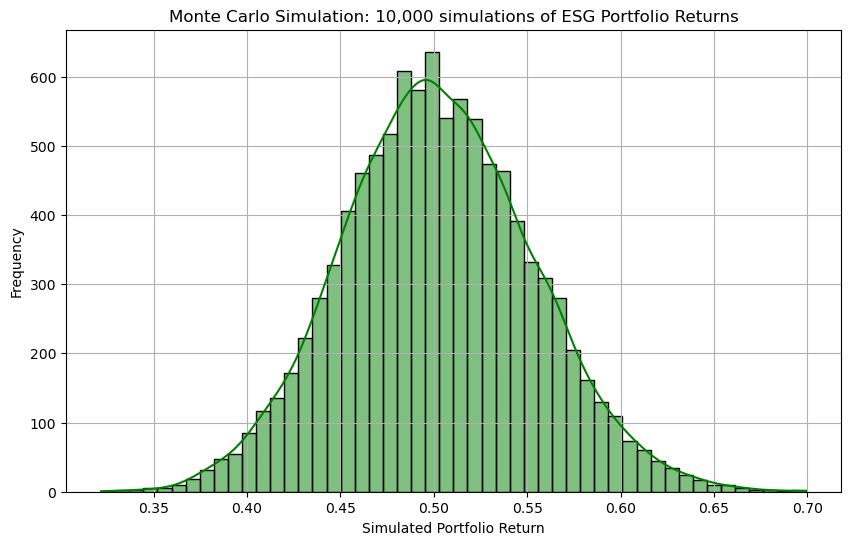

In [338]:
# Plot the distribution of the simulated returns
plt.figure(figsize=(10, 6))
sns.histplot(simulated_returns, kde=True, bins=50, color='green')
plt.title('Monte Carlo Simulation: 10,000 simulations of ESG Portfolio Returns')
plt.xlabel('Simulated Portfolio Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [340]:
# Step 6: K-Means Clustering on Financial and ESG Data

# Correct the column names to match the actual DataFrame columns
esg_and_financial_cols = [f'totalEsg_{company}' if company != 'Technology_Software' else 'totalEsg' 
                          for company in ['Energy', 'Financial_Services', 'Technology_Social', 'Technology_Software']] + \
                         [f'Close_{company}' if company != 'Technology_Software' else 'Close' 
                          for company in ['Energy', 'Financial_Services', 'Technology_Social', 'Technology_Software']]

# Extract the data for clustering
clustering_data = combined_data[esg_and_financial_cols].dropna()

# Display the selected data for clustering
print(clustering_data.head())



            totalEsg_Energy  totalEsg_Financial_Services  \
Date                                                       
2023-01-03             41.6                         28.3   
2023-01-04             41.6                         28.3   
2023-01-05             41.6                         28.3   
2023-01-06             41.6                         28.3   
2023-01-09             41.6                         28.3   

            totalEsg_Technology_Social  totalEsg  Close_Energy  \
Date                                                             
2023-01-03                       34.08     15.06    106.510002   
2023-01-04                       34.08     15.06    106.820000   
2023-01-05                       34.08     15.06    109.209999   
2023-01-06                       34.08     15.06    110.529999   
2023-01-09                       34.08     15.06    108.470001   

            Close_Financial_Services  Close_Technology_Social       Close  
Date                                    

In [350]:
# Standardize the data
scaler = StandardScaler()
scaled_clustering_data = scaler.fit_transform(clustering_data)

In [352]:
# Perform K-Means clustering (3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(scaled_clustering_data)

C:\Users\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


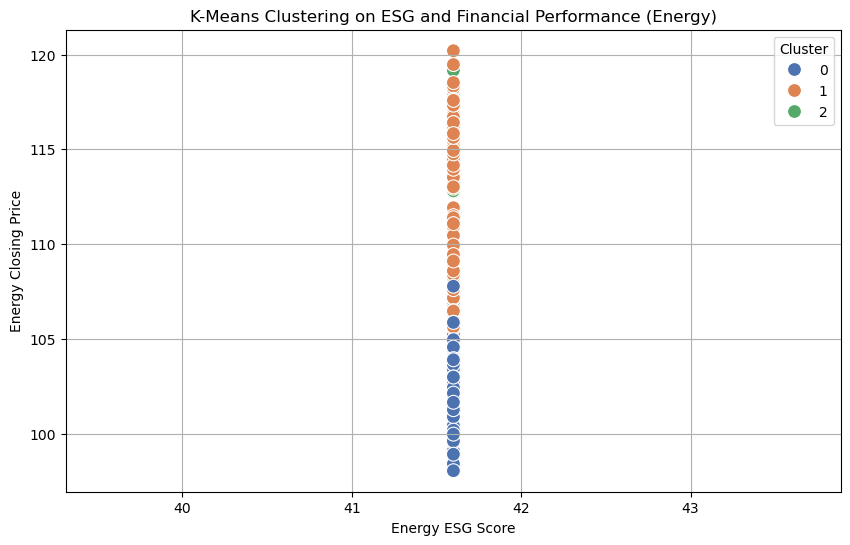

In [356]:
# Visualize the clusters on a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=clustering_data[f'totalEsg_Energy'], y=clustering_data[f'Close_Energy'], hue=clustering_data['Cluster'], palette='deep', s=100)
plt.title('K-Means Clustering on ESG and Financial Performance (Energy)')
plt.xlabel('Energy ESG Score')
plt.ylabel('Energy Closing Price')
plt.grid(True)
plt.show()


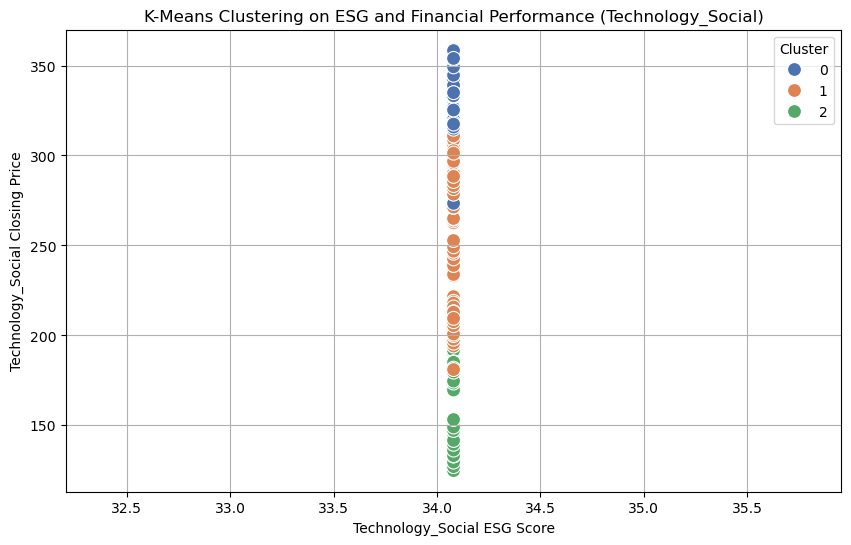

In [360]:
# Repeat visualization for another company (Technology Social)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=clustering_data[f'totalEsg_Technology_Social'], y=clustering_data[f'Close_Technology_Social'], hue=clustering_data['Cluster'], palette='deep', s=100)
plt.title('K-Means Clustering on ESG and Financial Performance (Technology_Social)')
plt.xlabel('Technology_Social ESG Score')
plt.ylabel('Technology_Social Closing Price')
plt.grid(True)
plt.show()


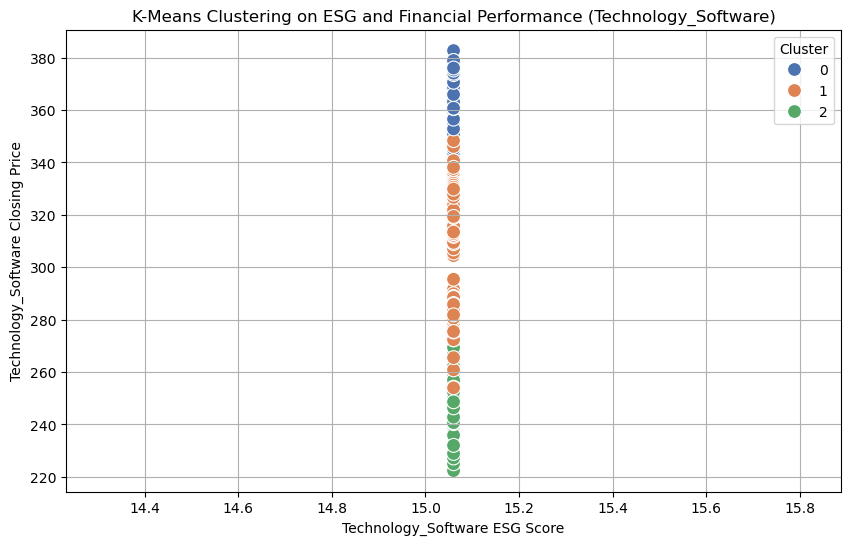

In [364]:
# Repeat visualization for another company (Technology Software)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=clustering_data['totalEsg'], y=clustering_data['Close'], hue=clustering_data['Cluster'], palette='deep', s=100)
plt.title('K-Means Clustering on ESG and Financial Performance (Technology_Software)')
plt.xlabel('Technology_Software ESG Score')
plt.ylabel('Technology_Software Closing Price')
plt.grid(True)
plt.show()


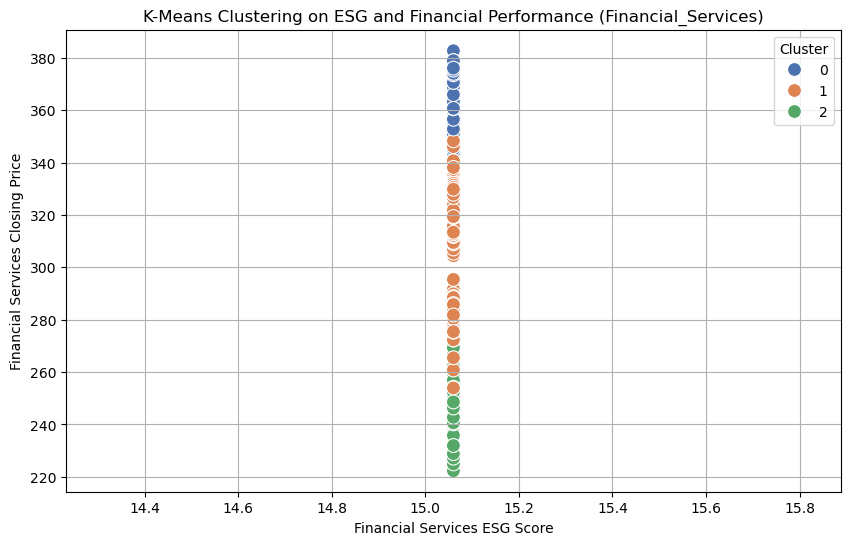

In [366]:
# Repeat visualization for another company (Financial Services)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=clustering_data['totalEsg'], y=clustering_data['Close'], hue=clustering_data['Cluster'], palette='deep', s=100)
plt.title('K-Means Clustering on ESG and Financial Performance (Financial_Services)')
plt.xlabel('Financial Services ESG Score')
plt.ylabel('Financial Services Closing Price')
plt.grid(True)
plt.show()

In [372]:
# Step 7: Cumulative Returns Based on ESG Scores

# Correct the column names for ESG scores
esg_columns = [f'totalEsg_{company}' if company != 'Technology_Software' else 'totalEsg'
               for company in ['Energy', 'Financial_Services', 'Technology_Social', 'Technology_Software']]

# Calculate cumulative returns based on percentage change in ESG scores for each company
cumulative_returns = (1 + combined_data[esg_columns].pct_change()).cumprod()

# Display cumulative returns
print(cumulative_returns)


            totalEsg_Energy  totalEsg_Financial_Services  \
Date                                                       
2023-01-03              NaN                          NaN   
2023-01-04              1.0                          1.0   
2023-01-05              1.0                          1.0   
2023-01-06              1.0                          1.0   
2023-01-09              1.0                          1.0   
...                     ...                          ...   
2023-12-22              1.0                          1.0   
2023-12-26              1.0                          1.0   
2023-12-27              1.0                          1.0   
2023-12-28              1.0                          1.0   
2023-12-29              1.0                          1.0   

            totalEsg_Technology_Social  totalEsg  
Date                                              
2023-01-03                         NaN       NaN  
2023-01-04                         1.0       1.0  
2023-01-05     

In [374]:
# Check the ESG scores data to verify if it's constant
print(combined_data[esg_columns].head(10))  # Display the first 10 rows


            totalEsg_Energy  totalEsg_Financial_Services  \
Date                                                       
2023-01-03             41.6                         28.3   
2023-01-04             41.6                         28.3   
2023-01-05             41.6                         28.3   
2023-01-06             41.6                         28.3   
2023-01-09             41.6                         28.3   
2023-01-10             41.6                         28.3   
2023-01-11             41.6                         28.3   
2023-01-12             41.6                         28.3   
2023-01-13             41.6                         28.3   
2023-01-17             41.6                         28.3   

            totalEsg_Technology_Social  totalEsg  
Date                                              
2023-01-03                       34.08     15.06  
2023-01-04                       34.08     15.06  
2023-01-05                       34.08     15.06  
2023-01-06              

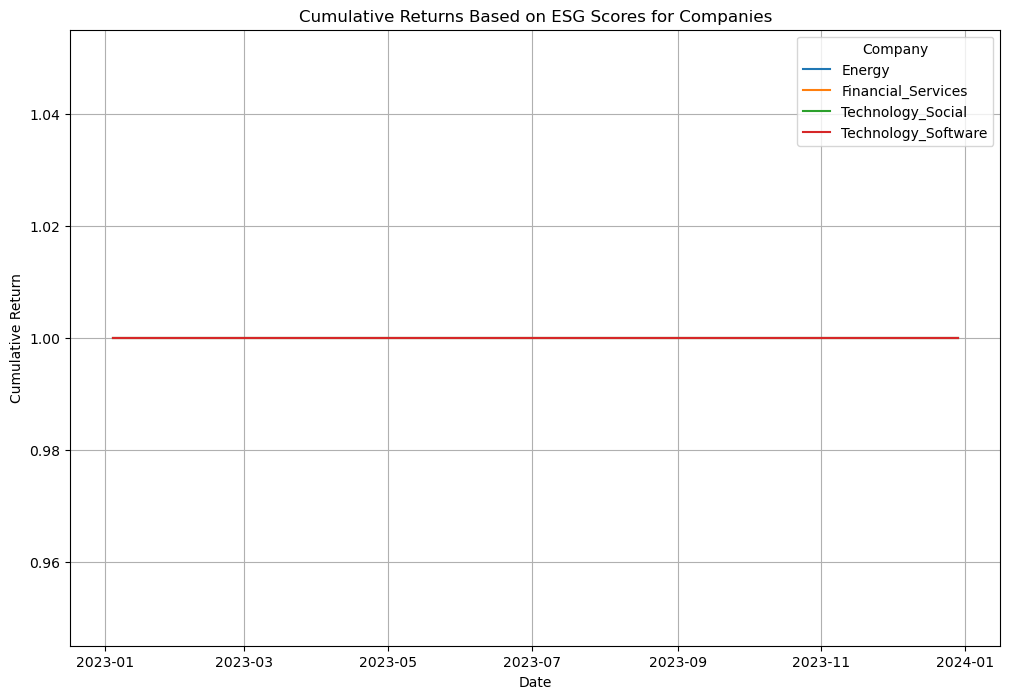

In [378]:
# Plot cumulative returns for each company
plt.figure(figsize=(12, 8))
for company in ['Energy', 'Financial_Services', 'Technology_Social', 'Technology_Software']:
    esg_col = f'totalEsg_{company}' if company != 'Technology_Software' else 'totalEsg'
    plt.plot(cumulative_returns.index, cumulative_returns[esg_col], label=company)

plt.title('Cumulative Returns Based on ESG Scores for Companies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(title="Company")
plt.grid(True)
plt.show()


In [384]:
print(X.columns)


Index(['totalEsg_Energy', 'totalEsg_Technology_Social',
       'totalEsg_Financial_Services', 'totalEsg', 'Energy_Volatility',
       'Financial_Services_Volatility', 'Technology_Social_Volatility',
       'Financial Services_Volatility', 'Technology Social_Volatility',
       'Technology Software_Volatility'],
      dtype='object')


In [386]:
X = X.loc[:, ~X.columns.duplicated()]


In [390]:
# Step 1: Clean the column names in X to avoid duplicates and inconsistencies
X.columns = X.columns.str.replace(' ', '_')  # Replace spaces with underscores for consistency
X = X.loc[:, ~X.columns.duplicated()]  # Remove duplicate columns if any

# Step 2: Extract feature importances from the previously trained Random Forest model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Step 3: Get the feature names in sorted order based on importance
feature_names = X.columns[indices]

# Step 4: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances[indices], color='teal')
plt.title('Feature Importance for Random Forest Model (ESG and Financial Metrics)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()


IndexError: index 9 is out of bounds for axis 0 with size 8

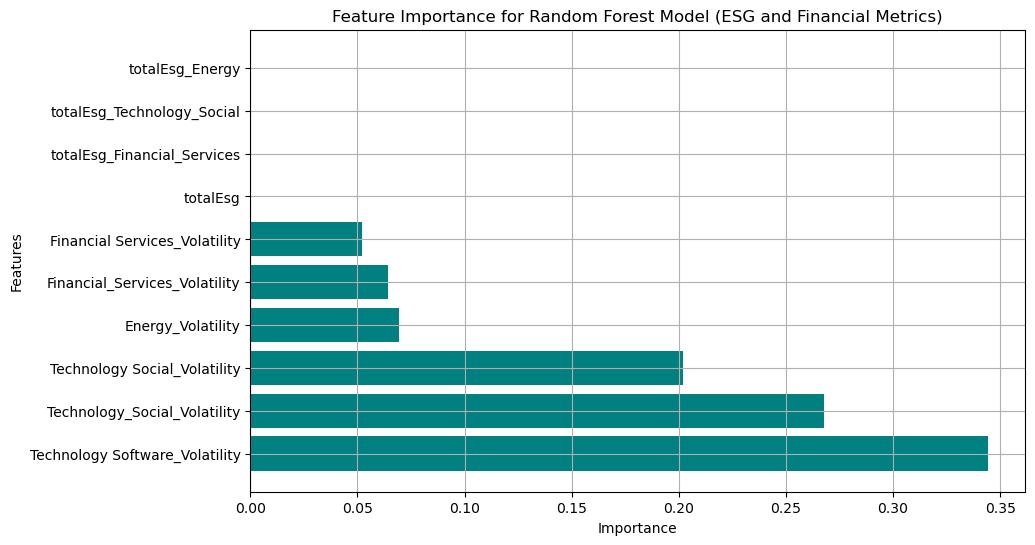

In [380]:
# Step 8: Feature Importance Using Random Forest for ESG and Financial Metrics

# Extract feature importances from the previously trained Random Forest model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh([X.columns[i] for i in indices], importances[indices], color='teal')
plt.title('Feature Importance for Random Forest Model (ESG and Financial Metrics)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()


Cross-validation scores:  [0.97142857 1.         0.94285714 1.         0.97142857]
Mean cross-validation score:  0.9771428571428572


C:\Users\Joseph Okpono\AppData\Local\Temp\ipykernel_29132\3391228618.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, 6)), y=cv_scores, palette='Blues_d')


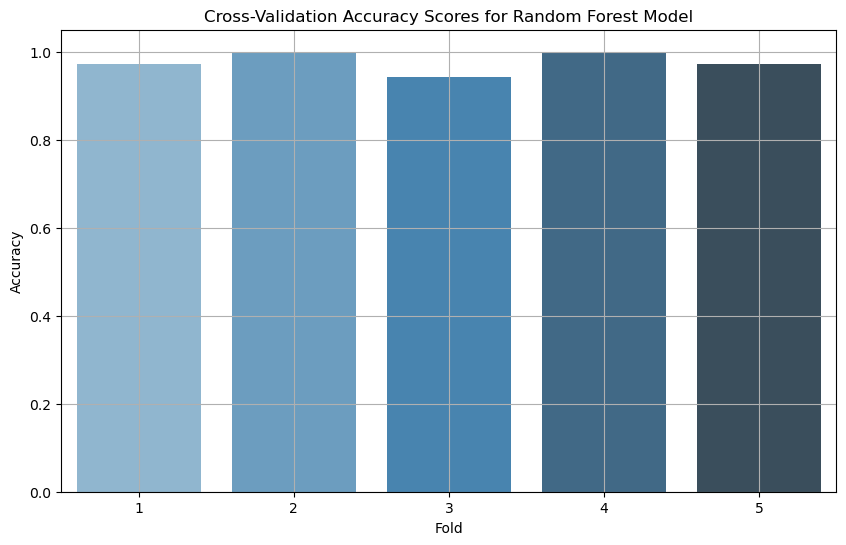

In [73]:
# Step 9: Cross-validation for the Random Forest Model

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the Random Forest model
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores and mean score
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", cv_scores.mean())

# Visualize the cross-validation scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(1, 6)), y=cv_scores, palette='Blues_d')
plt.title('Cross-Validation Accuracy Scores for Random Forest Model')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [75]:
# Step 10: Logistic Regression Model for Comparison

from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model to compare with the Random Forest
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_logistic = logistic_model.predict(X_test_scaled)

# Display classification report for Logistic Regression
classification_report_logistic = classification_report(y_test, y_pred_logistic)
print(classification_report_logistic)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      0.97      0.99        37

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



In [77]:
# Cross-validation for Logistic Regression
cv_scores_logistic = cross_val_score(logistic_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores for Logistic Regression
print("Cross-validation scores (Logistic Regression): ", cv_scores_logistic)
print("Mean cross-validation score (Logistic Regression): ", cv_scores_logistic.mean())


Cross-validation scores (Logistic Regression):  [0.91428571 0.97142857 0.97142857 1.         0.97142857]
Mean cross-validation score (Logistic Regression):  0.9657142857142856


C:\Users\Joseph Okpono\AppData\Local\Temp\ipykernel_29132\722852230.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, 6)), y=cv_scores_logistic, palette='Greens_d')


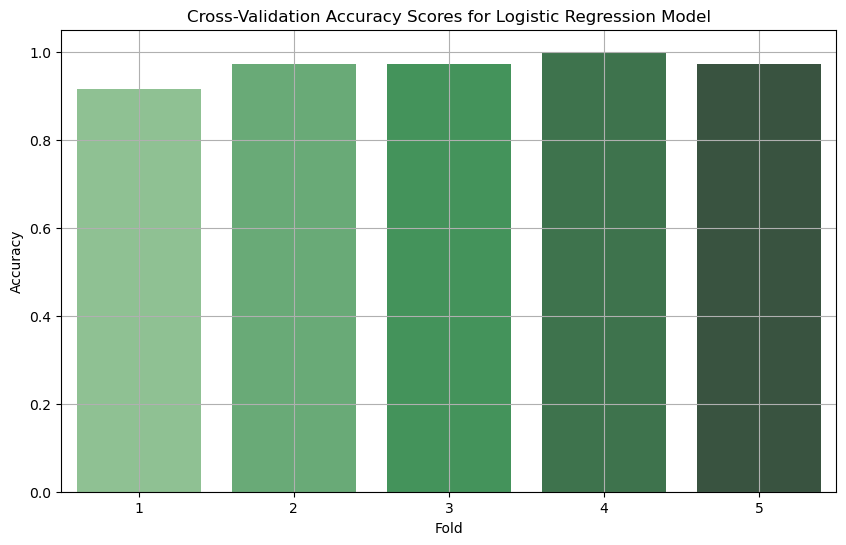

In [79]:
# Visualize the cross-validation scores for Logistic Regression
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(1, 6)), y=cv_scores_logistic, palette='Greens_d')
plt.title('Cross-Validation Accuracy Scores for Logistic Regression Model')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [81]:
# Step 11: Ensemble Model with Voting Classifier

from sklearn.ensemble import VotingClassifier

# Set up the Voting Classifier with Random Forest, Logistic Regression, and another model (e.g., SVM)
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Create an ensemble model using soft voting
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('logistic', logistic_model),
        ('svm', svm_model)
    ],
    voting='soft'  # Soft voting averages the predicted probabilities
)

# Train the ensemble model
ensemble_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_ensemble = ensemble_model.predict(X_test_scaled)

# Display classification report for the ensemble model
classification_report_ensemble = classification_report(y_test, y_pred_ensemble)
print(classification_report_ensemble)


              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      0.97      0.99        37

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



Cross-validation scores (Ensemble):  [0.94285714 1.         0.97142857 1.         1.        ]
Mean cross-validation score (Ensemble):  0.9828571428571429


C:\Users\Joseph Okpono\AppData\Local\Temp\ipykernel_29132\2527859206.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, 6)), y=cv_scores_ensemble, palette='Oranges_d')


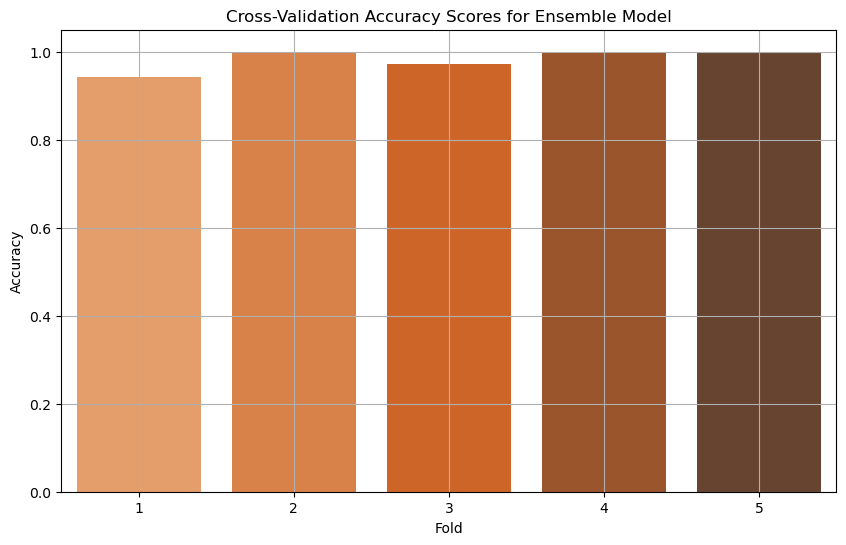

In [83]:
# Cross-validation for ensemble model
cv_scores_ensemble = cross_val_score(ensemble_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores for the ensemble model
print("Cross-validation scores (Ensemble): ", cv_scores_ensemble)
print("Mean cross-validation score (Ensemble): ", cv_scores_ensemble.mean())

# Visualize cross-validation scores for the ensemble model
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(1, 6)), y=cv_scores_ensemble, palette='Oranges_d')
plt.title('Cross-Validation Accuracy Scores for Ensemble Model')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [85]:
# Step 12: Deep Learning - LSTM for Time-Series ESG Score Prediction

from keras.models import Sequential
from keras.layers import LSTM, Dense

# Prepare data for LSTM (reshape to 3D [samples, time_steps, features])
def prepare_lstm_data(data, time_steps=30):
    X_lstm, y_lstm = [], []
    for i in range(len(data) - time_steps):
        X_lstm.append(data[i:(i + time_steps), :])
        y_lstm.append(data[i + time_steps, 0])  # Predict based on ESG score of one company
    return np.array(X_lstm), np.array(y_lstm)

In [87]:
# Extract ESG and financial data for LSTM
esg_and_financial_data = combined_data[esg_and_financial_cols].values

# Prepare LSTM input data
X_lstm, y_lstm = prepare_lstm_data(esg_and_financial_data)

In [89]:
# Split data into training and testing sets for LSTM
split_index = int(0.8 * len(X_lstm))
X_lstm_train, X_lstm_test = X_lstm[:split_index], X_lstm[split_index:]
y_lstm_train, y_lstm_test = y_lstm[:split_index], y_lstm[split_index:]

In [91]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\Joseph Okpono\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [93]:
# Train the LSTM model
lstm_model.fit(X_lstm_train, y_lstm_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1684.1633
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1576.2194 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1473.8824 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1369.9912 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1281.7754 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1195.9368 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1112.3033 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1043.8301 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 989.2886 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 946.8718 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 911.8033 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 880.7195 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 851.9335 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 825.5407 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

In [95]:
# Predict on the test set
y_lstm_pred = lstm_model.predict(X_lstm_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


In [97]:
# Evaluate the LSTM model
def evaluate_lstm(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    rmse = np.sqrt(mean_squared_error(y_true_filtered, y_pred_filtered))
    mape = mean_absolute_percentage_error(y_true_filtered, y_pred_filtered)
    return rmse, mape


In [99]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Evaluate and display the performance of the LSTM model
lstm_rmse, lstm_mape = evaluate_lstm(y_lstm_test, y_lstm_pred)
print(f"RMSE: {lstm_rmse}")
print(f"MAPE: {lstm_mape}")


RMSE: 8.159787750244142
MAPE: 0.19614874399625346


In [101]:
def prepare_lstm_data(data, time_steps=30):
    X_lstm, y_lstm = [], []
    for i in range(len(data) - time_steps):
        X_lstm.append(data[i:(i + time_steps), :])
        y_lstm.append(data[i + time_steps, 0])  # Predict based on ESG score of one company
    return np.array(X_lstm), np.array(y_lstm)


In [103]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_lstm_train, y_lstm_train, epochs=100, batch_size=32, verbose=1)


Epoch 1/100


C:\Users\Joseph Okpono\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1716.1859
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1617.1031 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1531.1938 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1443.0525 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1350.5820 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1269.9722 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1201.6129 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1138.2048 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1081.6265 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1033.7040 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 992.4603  
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 956.2063 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 925.1805 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 897.9828 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8

In [105]:
# Predict on the test set
y_lstm_pred = lstm_model.predict(X_lstm_test)

# Evaluate the LSTM model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Function to evaluate RMSE and MAPE
def evaluate_lstm(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    rmse = np.sqrt(mean_squared_error(y_true_filtered, y_pred_filtered))
    mape = mean_absolute_percentage_error(y_true_filtered, y_pred_filtered)
    return rmse, mape

# Evaluate and display the performance
lstm_rmse, lstm_mape = evaluate_lstm(y_lstm_test, y_lstm_pred)
print(f"RMSE: {lstm_rmse}, MAPE: {lstm_mape}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
RMSE: 9.065499791232043, MAPE: 0.21792066805846205


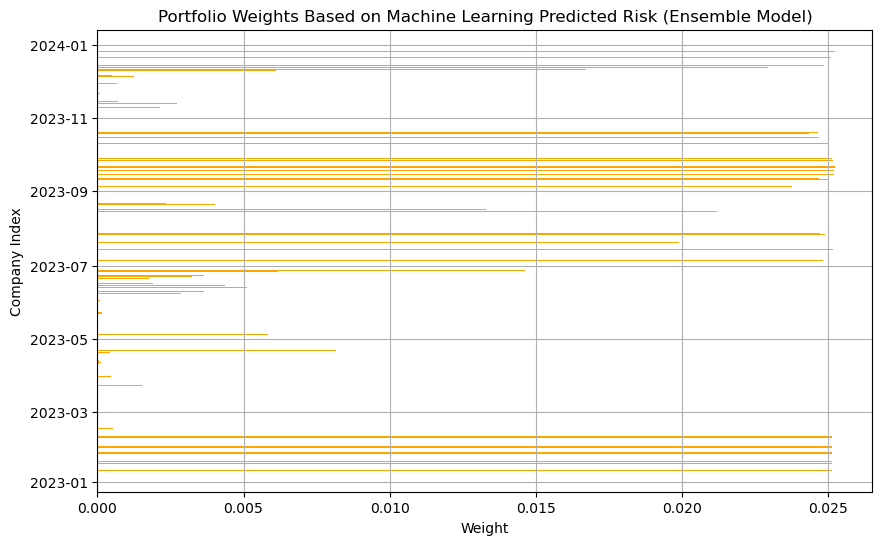

In [107]:
# Step 13: Portfolio Optimization Based on Machine Learning Predictions

# Normalize the predicted risks from the ensemble model to use them for portfolio weighting
predicted_risk = ensemble_model.predict_proba(X_test_scaled)[:, 1]  # Probability of being high risk

# Normalize predicted risk to create portfolio weights (lower risk gets higher weight)
normalized_risk = 1 - predicted_risk  # Invert risk to prioritize lower risk companies
portfolio_weights_ml = normalized_risk / normalized_risk.sum()

# Visualize portfolio weights based on predicted risk from the ensemble model
plt.figure(figsize=(10, 6))
plt.barh(X_test.index, portfolio_weights_ml, color='orange')
plt.title('Portfolio Weights Based on Machine Learning Predicted Risk (Ensemble Model)')
plt.xlabel('Weight')
plt.ylabel('Company Index')
plt.grid(True)
plt.show()

In [109]:
# Step 14: Comparison of Machine Learning Models

# Display the results of cross-validation for all models
models_performance = {
    "Random Forest": cv_scores.mean(),
    "Logistic Regression": cv_scores_logistic.mean(),
    "Ensemble Model": cv_scores_ensemble.mean()
}

C:\Users\Joseph Okpono\AppData\Local\Temp\ipykernel_29132\1520692682.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models_performance.keys()), y=list(models_performance.values()), palette='viridis')


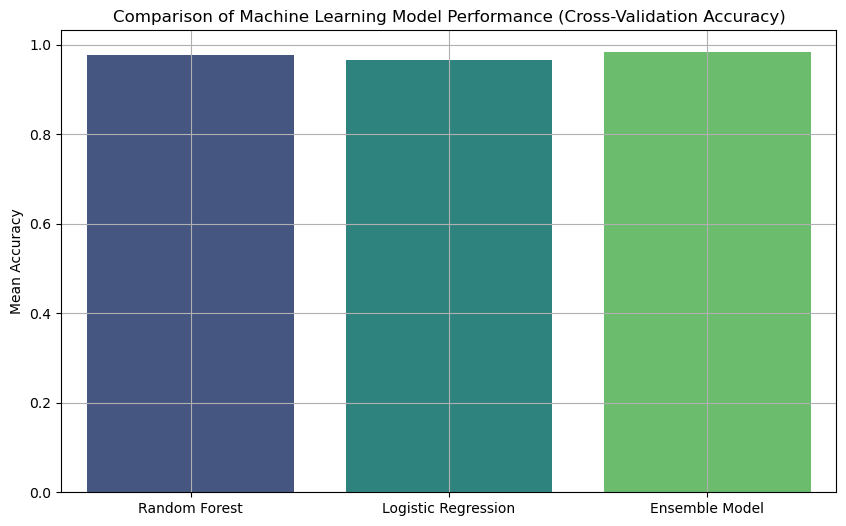

In [111]:
# Visualize the comparison of model performance
plt.figure(figsize=(10, 6))
sns.barplot(x=list(models_performance.keys()), y=list(models_performance.values()), palette='viridis')
plt.title('Comparison of Machine Learning Model Performance (Cross-Validation Accuracy)')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

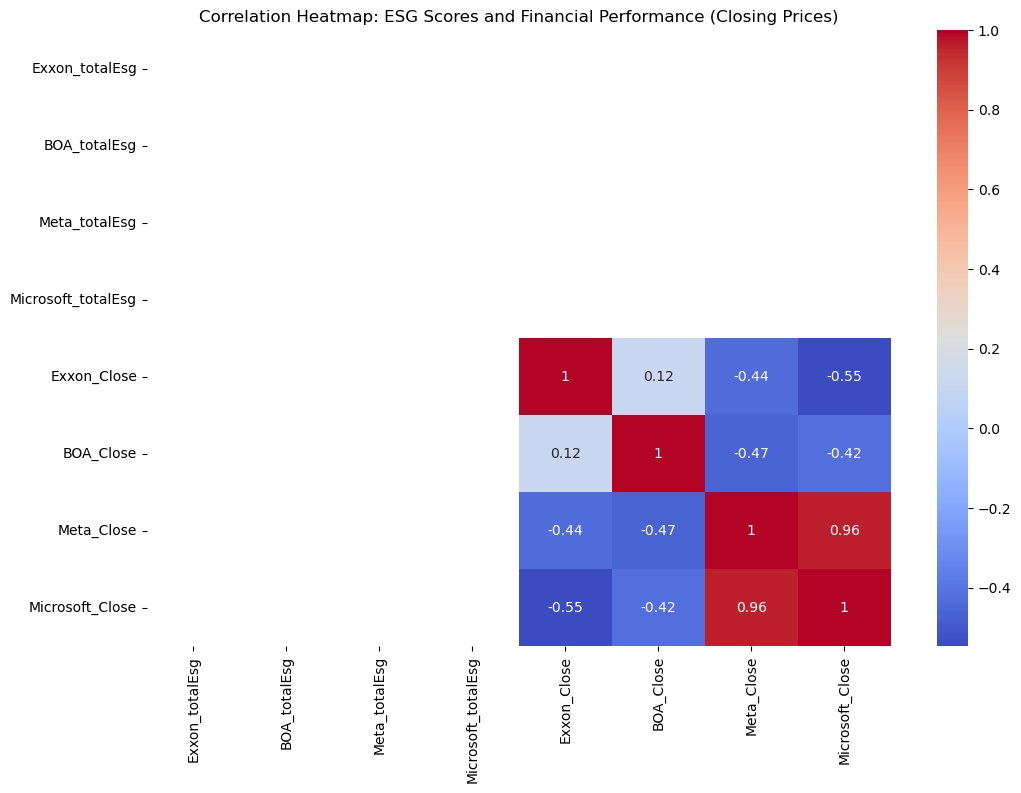

In [113]:
# Step 15: Data Analytics and Visualization for Deep Insights

# Analyzing Correlation Between ESG Scores and Financial Performance

# Calculate the correlation matrix for ESG scores and closing prices
esg_and_financial_cols = [f'{company}_totalEsg' for company in ['Exxon', 'BOA', 'Meta', 'Microsoft']] + \
                         [f'{company}_Close' for company in ['Exxon', 'BOA', 'Meta', 'Microsoft']]
corr_matrix = combined_data[esg_and_financial_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: ESG Scores and Financial Performance (Closing Prices)')
plt.show()


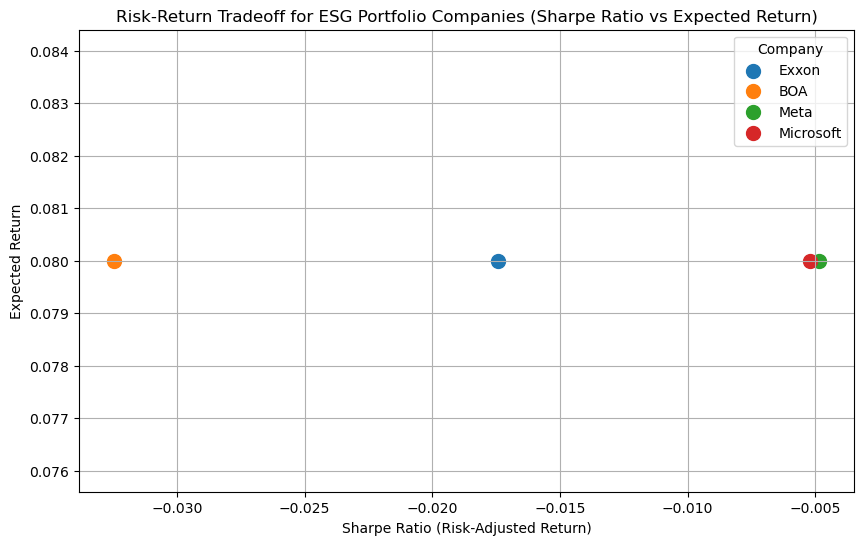

In [115]:
# Step 16: Risk-Return Tradeoff Visualization
# Visualizing the risk-return tradeoff for each company using Sharpe Ratios and Expected Returns

plt.figure(figsize=(10, 6))

for company in financial_metrics.keys():
    sharpe_ratio = financial_metrics[company]['Sharpe Ratio']
    expected_return = financial_metrics[company]['Expected Return']
    plt.scatter(sharpe_ratio, expected_return, label=company, s=100)

plt.title('Risk-Return Tradeoff for ESG Portfolio Companies (Sharpe Ratio vs Expected Return)')
plt.xlabel('Sharpe Ratio (Risk-Adjusted Return)')
plt.ylabel('Expected Return')
plt.legend(title="Company")
plt.grid(True)
plt.show()

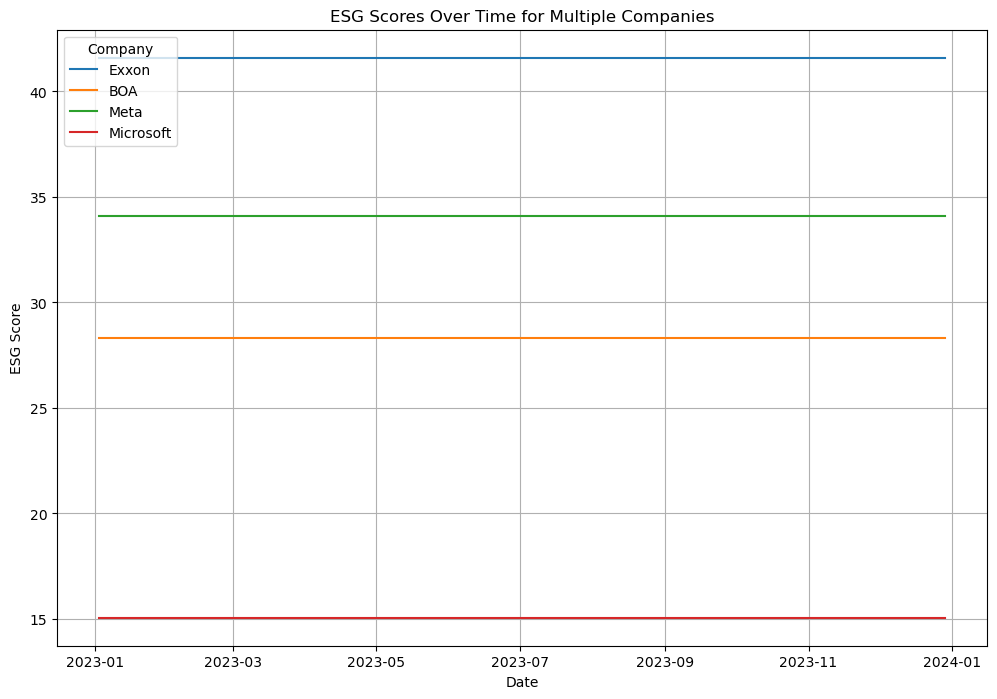

In [117]:
# Step 17: ESG Scores Over Time - Time Series Visualization
plt.figure(figsize=(12, 8))

for company in ['Exxon', 'BOA', 'Meta', 'Microsoft']:
    company_esg_col = f'{company}_totalEsg'
    plt.plot(combined_data.index, combined_data[company_esg_col], label=company)

plt.title("ESG Scores Over Time for Multiple Companies")
plt.xlabel("Date")
plt.ylabel("ESG Score")
plt.legend(title="Company")
plt.grid(True)
plt.show()

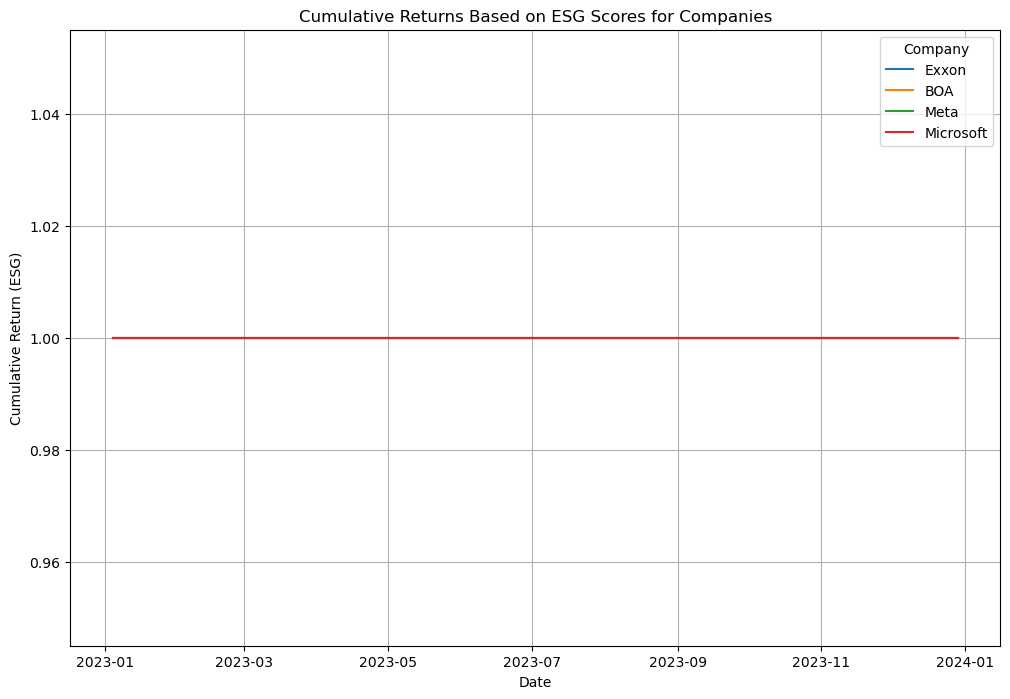

In [119]:
# Step 18: Cumulative Returns Based on ESG Scores
# Calculate cumulative returns using percentage change in ESG scores over time for each company

cumulative_returns_esg = (1 + combined_data[[f'{company}_totalEsg' for company in ['Exxon', 'BOA', 'Meta', 'Microsoft']]].pct_change()).cumprod()

# Plot the cumulative returns for each company's ESG score
plt.figure(figsize=(12, 8))
for company in ['Exxon', 'BOA', 'Meta', 'Microsoft']:
    plt.plot(cumulative_returns_esg.index, cumulative_returns_esg[f'{company}_totalEsg'], label=company)

plt.title('Cumulative Returns Based on ESG Scores for Companies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (ESG)')
plt.legend(title="Company")
plt.grid(True)
plt.show()

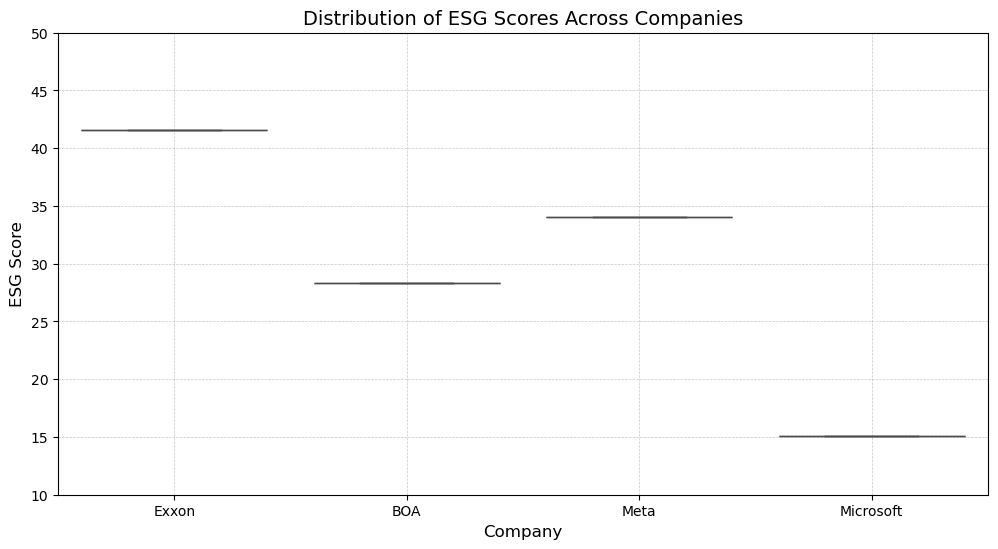

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improved boxplot code
plt.figure(figsize=(12, 6))

# Define the colors for better differentiation
palette = ["#4c72b0", "#55a868", "#c44e52", "#8172b3"]

# Create the boxplot with a defined color palette
sns.boxplot(data=combined_data[[f'{company}_totalEsg' for company in ['Exxon', 'BOA', 'Meta', 'Microsoft']]], palette=palette)

# Add title and labels
plt.title('Distribution of ESG Scores Across Companies', fontsize=14)
plt.ylabel('ESG Score', fontsize=12)
plt.xlabel('Company', fontsize=12)

# Set custom x-tick labels to represent companies clearly
plt.xticks([0, 1, 2, 3], ['Exxon', 'BOA', 'Meta', 'Microsoft'], fontsize=10)

# Add grid for better readability with lighter gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Optionally, set y-axis limits for better comparison (adjust as needed)
plt.ylim(10, 50)

# Show the plot
plt.show()


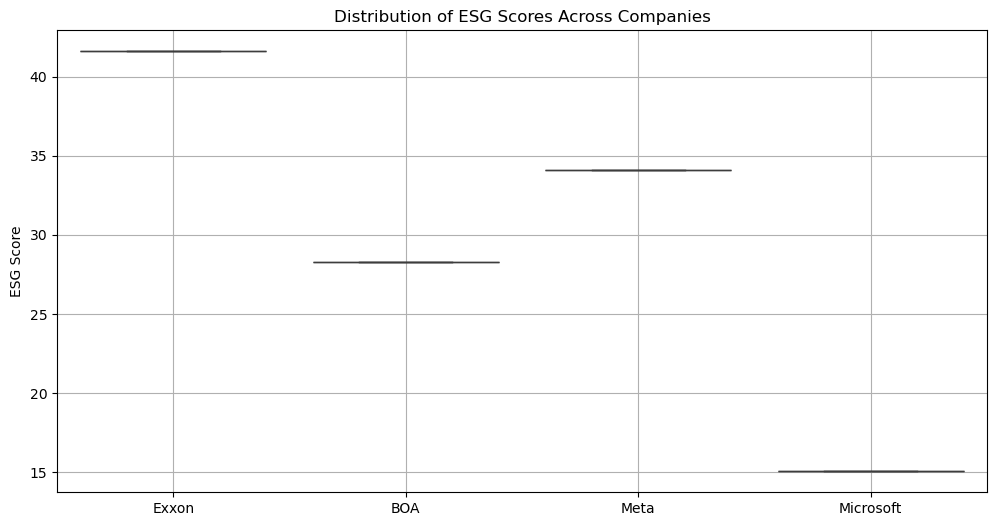

In [123]:
# Step 19: Boxplot of ESG Scores to Visualize Distribution
# Create boxplots to show the distribution of ESG scores across the companies

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_data[[f'{company}_totalEsg' for company in ['Exxon', 'BOA', 'Meta', 'Microsoft']]])
plt.title('Distribution of ESG Scores Across Companies')
plt.ylabel('ESG Score')
plt.xticks([0, 1, 2, 3], ['Exxon', 'BOA', 'Meta', 'Microsoft'])
plt.grid(True)
plt.show()

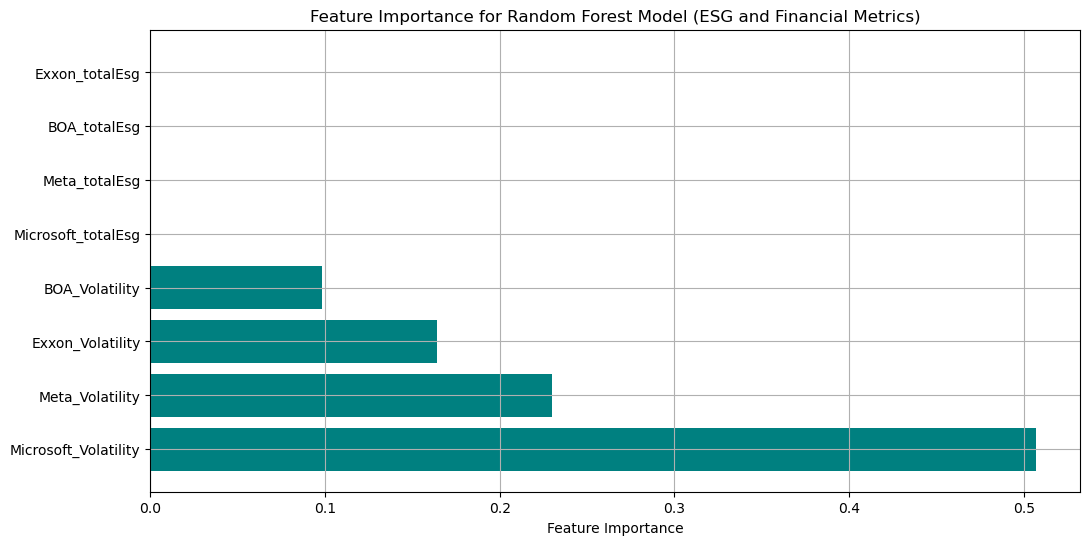

In [125]:
# Step 20: Feature Importance from Random Forest Model
# Using the feature importance from the Random Forest model to understand the most influential factors

importances_rf = rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

# Plot feature importance for ESG and financial metrics
plt.figure(figsize=(12, 6))
plt.barh([X.columns[i] for i in indices_rf], importances_rf[indices_rf], color='teal')
plt.title('Feature Importance for Random Forest Model (ESG and Financial Metrics)')
plt.xlabel('Feature Importance')
plt.grid(True)
plt.show()

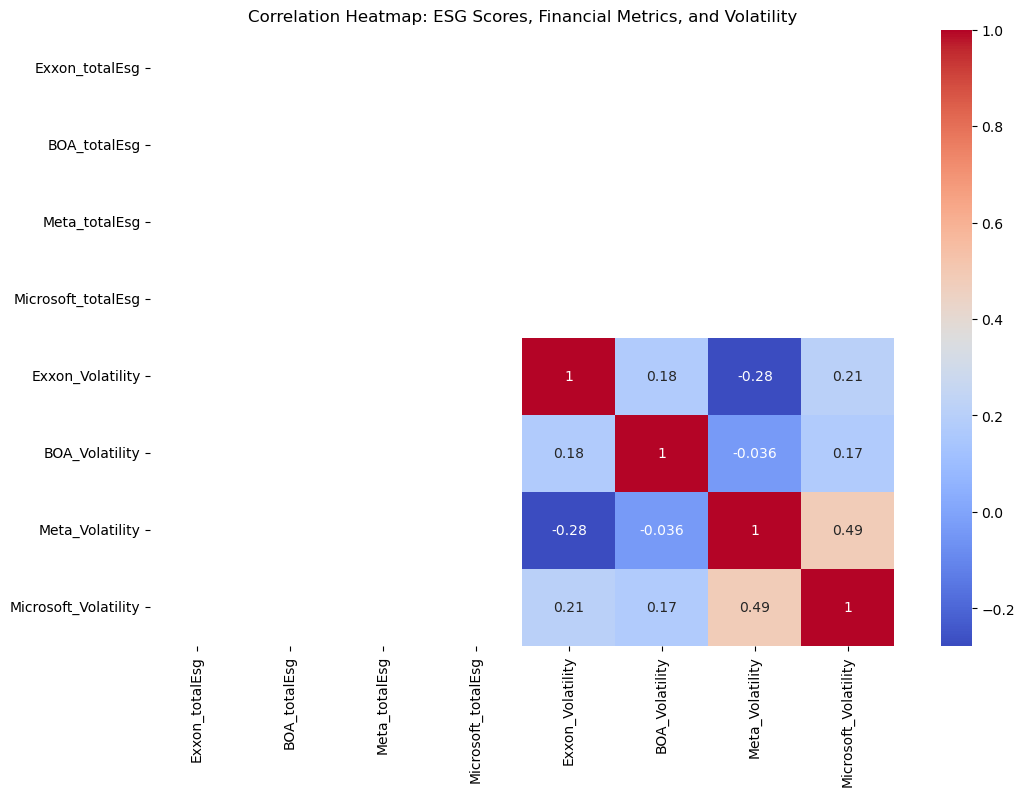

In [127]:
# Step 21: Heatmap of ESG Scores and Financial Metrics Correlations with Volatility
# Examine the relationship between ESG scores, financial metrics, and volatility

volatility_cols = [f'{company}_Volatility' for company in ['Exxon', 'BOA', 'Meta', 'Microsoft']]
esg_and_volatility_corr = combined_data[[f'{company}_totalEsg' for company in ['Exxon', 'BOA', 'Meta', 'Microsoft']] + volatility_cols].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(esg_and_volatility_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: ESG Scores, Financial Metrics, and Volatility')
plt.show()

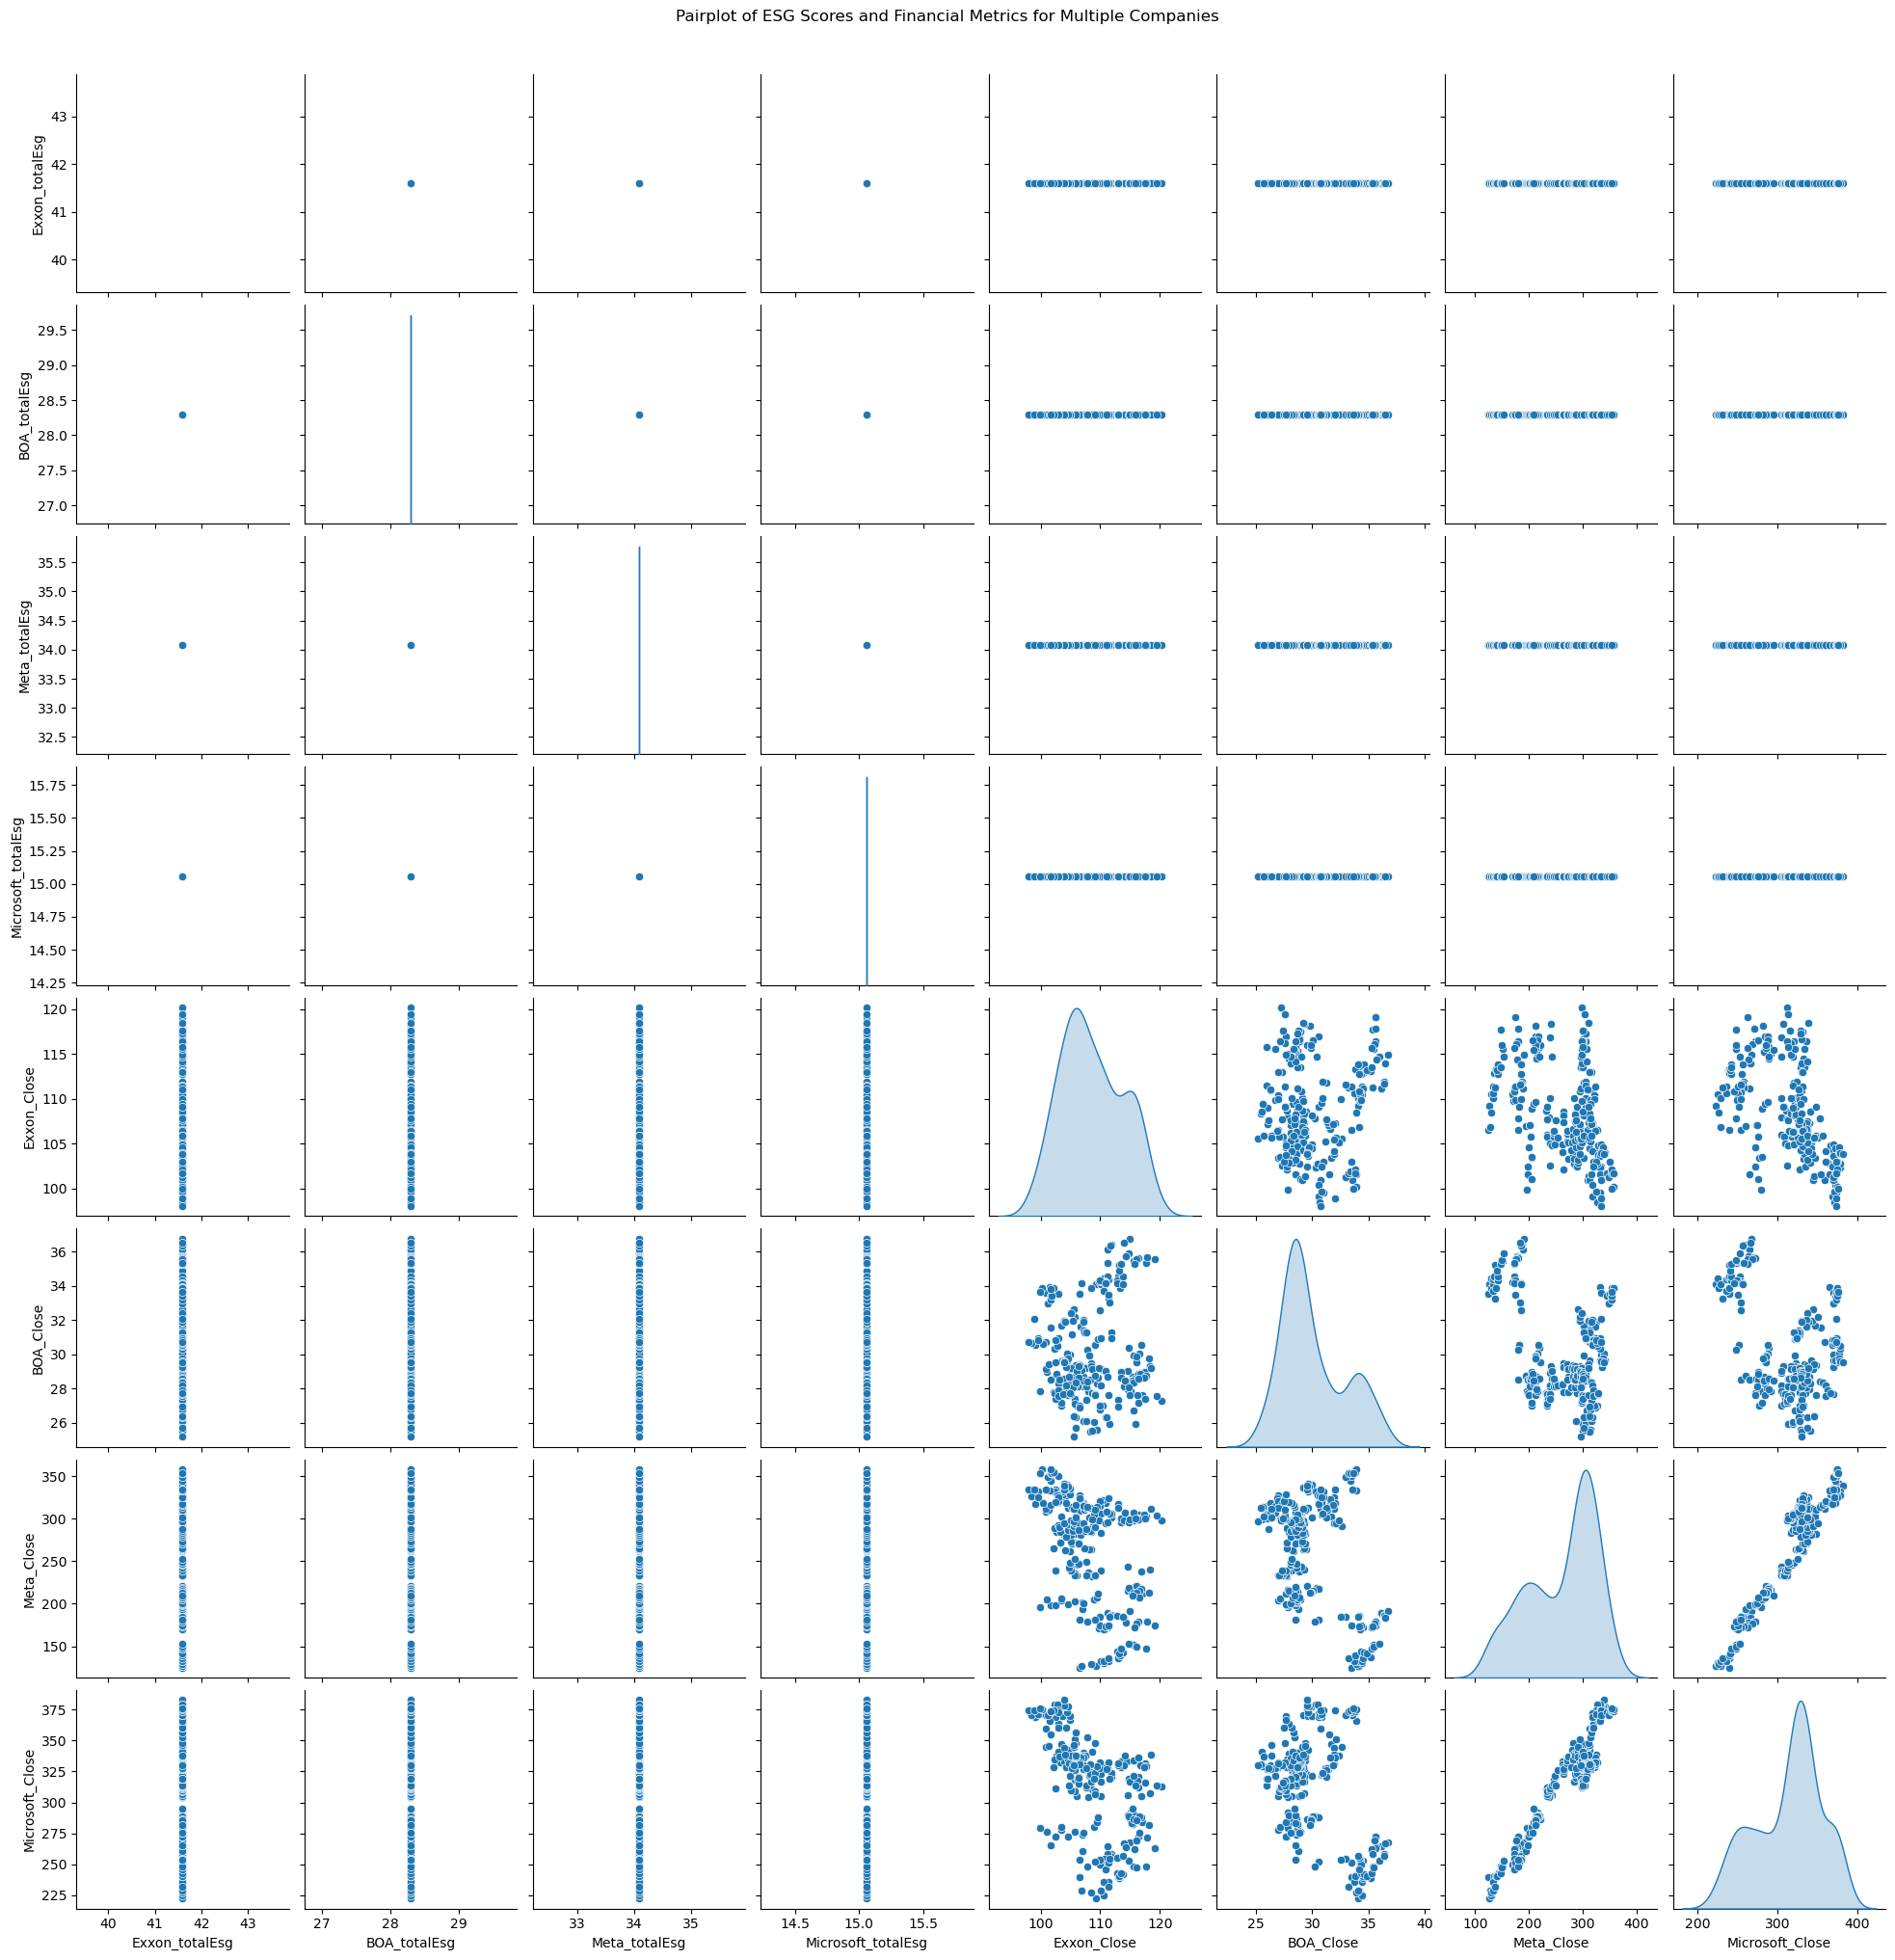

In [129]:
# Step 22: Pairplot for Relationships Between ESG Scores and Financial Metrics
# Visualize the pairwise relationships between ESG scores and financial metrics to explore deeper insights

# Selecting ESG and financial metrics for the pairplot
esg_and_financial_cols = [f'{company}_totalEsg' for company in ['Exxon', 'BOA', 'Meta', 'Microsoft']] + \
                         [f'{company}_Close' for company in ['Exxon', 'BOA', 'Meta', 'Microsoft']]

# Plot pairplot to visualize relationships
sns.pairplot(combined_data[esg_and_financial_cols], diag_kind="kde")
plt.suptitle("Pairplot of ESG Scores and Financial Metrics for Multiple Companies", y=1.02)
plt.show()

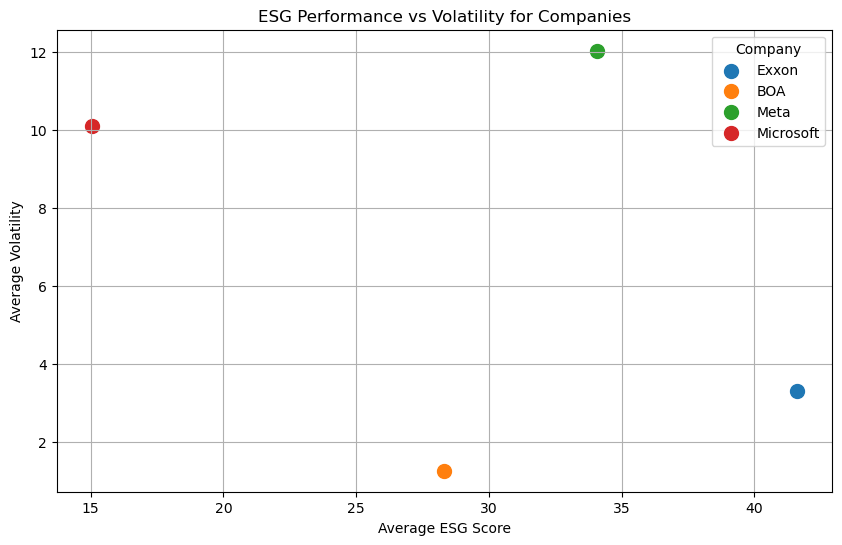

In [130]:
# Step 23: Visualizing ESG Performance vs Volatility
# Scatter plot comparing ESG performance and average volatility for each company

plt.figure(figsize=(10, 6))
for company in ['Exxon', 'BOA', 'Meta', 'Microsoft']:
    company_esg_col = f'{company}_totalEsg'
    company_volatility_col = f'{company}_Volatility'
    plt.scatter(combined_data[company_esg_col].mean(), combined_data[company_volatility_col].mean(), label=company, s=100)

plt.title("ESG Performance vs Volatility for Companies")
plt.xlabel("Average ESG Score")
plt.ylabel("Average Volatility")
plt.legend(title="Company")
plt.grid(True)
plt.show()

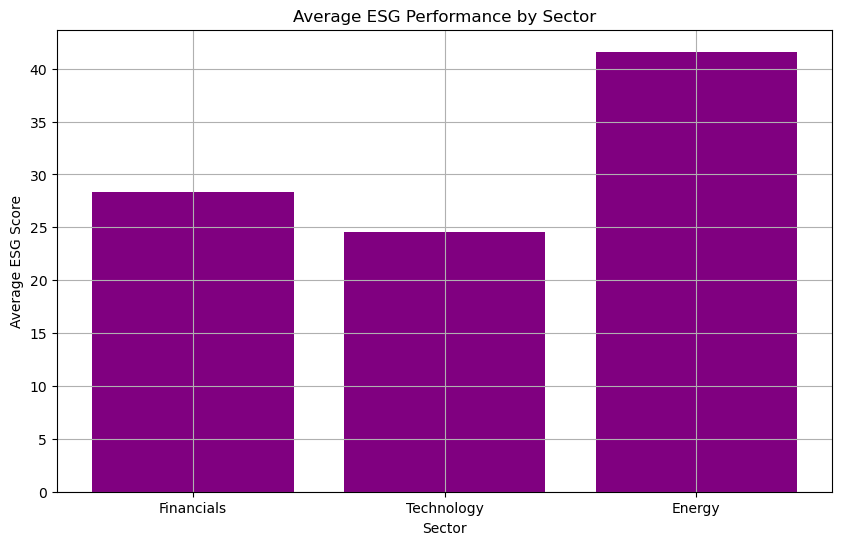

In [131]:
# Assuming we have the combined ESG data from multiple companies and their respective sectors

# Example sector information for the companies (this would normally come from the dataset)
sectors = {
    'Exxon': 'Energy',
    'BOA': 'Financials',
    'Meta': 'Technology',
    'Microsoft': 'Technology'
}

# Calculate the average ESG score for each sector
sector_performance = {sector: combined_data[[f'{company}_totalEsg' for company, sec in sectors.items() if sec == sector]].mean(axis=1).mean() for sector in set(sectors.values())}

# Plotting sector-wise ESG performance
plt.figure(figsize=(10, 6))
plt.bar(sector_performance.keys(), sector_performance.values(), color='purple')
plt.title('Average ESG Performance by Sector')
plt.xlabel('Sector')
plt.ylabel('Average ESG Score')
plt.grid(True)
plt.show()
